In [24]:
%matplotlib inline
import numpy as np
import scipy as sp
import pandas as pd
import datetime


from matplotlib import pyplot as plt
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pandas.tools.plotting import autocorrelation_plot
from pandas.plotting import register_matplotlib_converters

df_dji = pd.read_csv("data/DJI.csv") ## Reading DJI
df_sp500 = pd.read_csv('data/S&P500.csv')
file = pd.ExcelFile("data/GAS.xls")   ## Load the gas prices database
df_nas = pd.read_csv('data/NASDAQ.csv')

#Column selection
df_gas= file.parse('Data 1', header=2, ncolumns=2) # Parse the file, saving as our database
df_gas = df_gas[['Date', 'Weekly U.S. All Grades All Formulations Retail Gasoline Prices  (Dollars per Gallon)']]
df_gas = df_gas.rename(index=str, columns={"Weekly U.S. All Grades All Formulations Retail Gasoline Prices  (Dollars per Gallon)": "gas_price"})
df_gas_copy = df_gas.copy()  # need to copy gas here before the offsets
df_gas['Date'] = df_gas.Date + pd.offsets.MonthBegin(1) #setting date from the 15th to the 1st
df_nas = df_nas[['Date', 'Close']]
#Stocks
df_dji = df_dji[['Date', 'Close']]
df_sp500 = df_sp500[['Date', 'Close']]

#Dropping NaN values
df_gas.dropna(axis=0, inplace=True)
df_sp500.dropna(axis=0, inplace=True)
df_dji.dropna(axis=0, inplace=True)
df_nas.dropna(axis=0, inplace=True)


#Converting dates from string to datetime
df_dji['Date'] = pd.to_datetime(df_dji.Date)
df_sp500['Date'] = pd.to_datetime(df_sp500.Date)
df_gas_copy['Date'] = pd.to_datetime(df_gas_copy.Date)
df_nas['Date'] = pd.to_datetime(df_nas.Date)

#merging
#df = df_dji.merge(df_sp500, how='inner', on='Date')
#df = df.merge(df_gas, how='inner', on='Date')


In [29]:
#Set indexes
df_gas.set_index('Date', inplace = True)
df_dji.set_index('Date', inplace = True)
df_gas_copy.set_index('Date', inplace = True)
df_sp500.set_index('Date', inplace = True)
df_nas.set_index('Date', inplace = True)
#Make copies of the dataframes
df_dji_copy = df_dji.copy()
df_sp500_copy = df_sp500.copy()
df_nas_copy = df_nas.copy()
#Rename Columns for our Master/Cross-Correlational Dataframe
df_dji_copy = df_dji.rename(columns ={'Close': "DJI"})
df_sp500_copy = df_sp500.rename(columns ={'Close': "SP500"})
df_nas_copy = df_nas.rename(columns ={'Close': "NASDAQ"})


KeyError: 'Date'

In [ ]:
#Construct Correlation Dataframe relative to gas
df_corr_gas = pd.concat([df_gas_copy, df_dji_copy, df_sp500_copy, df_nas_copy], axis=1, join_axes=[df_gas_copy.index])
df_corr_gas.dropna(axis=0, inplace = True)   #Drop null values

#Construct Correlation Dataframe for stocks
df_corr_stocks = pd.concat([df_dji_copy, df_sp500_copy, df_nas_copy], axis=1, join_axes=[df_dji_copy.index])
df_corr_gas

In [30]:
df_gas

,gas_price
Date,
1993-05-01,1.068
1993-05-01,1.079
1993-05-01,1.079
1993-05-01,1.086
1993-06-01,1.086
1993-06-01,1.097
1993-06-01,1.106
1993-06-01,1.106
1993-06-01,1.107


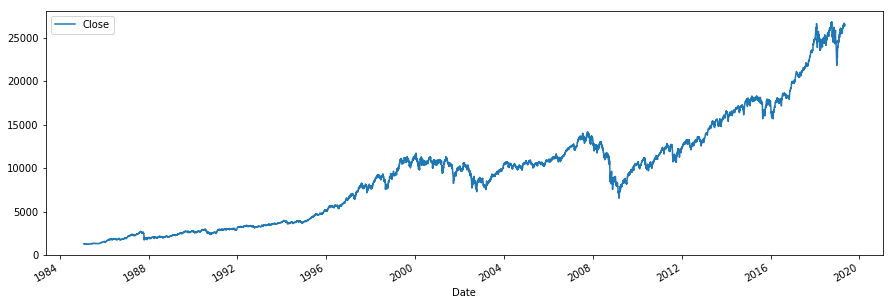

In [31]:
df_dji.plot(figsize = (15, 5))

In [32]:
df_dji_week = pd.DataFrame(df_dji.resample('W').mean())
df_dji_week.head()

,Close
Date,
1985-02-03,1286.247498
1985-02-10,1287.189966
1985-02-17,1284.098023
1985-02-24,1279.649994
1985-03-03,1285.602002


## Manual Parameter Selection (d)

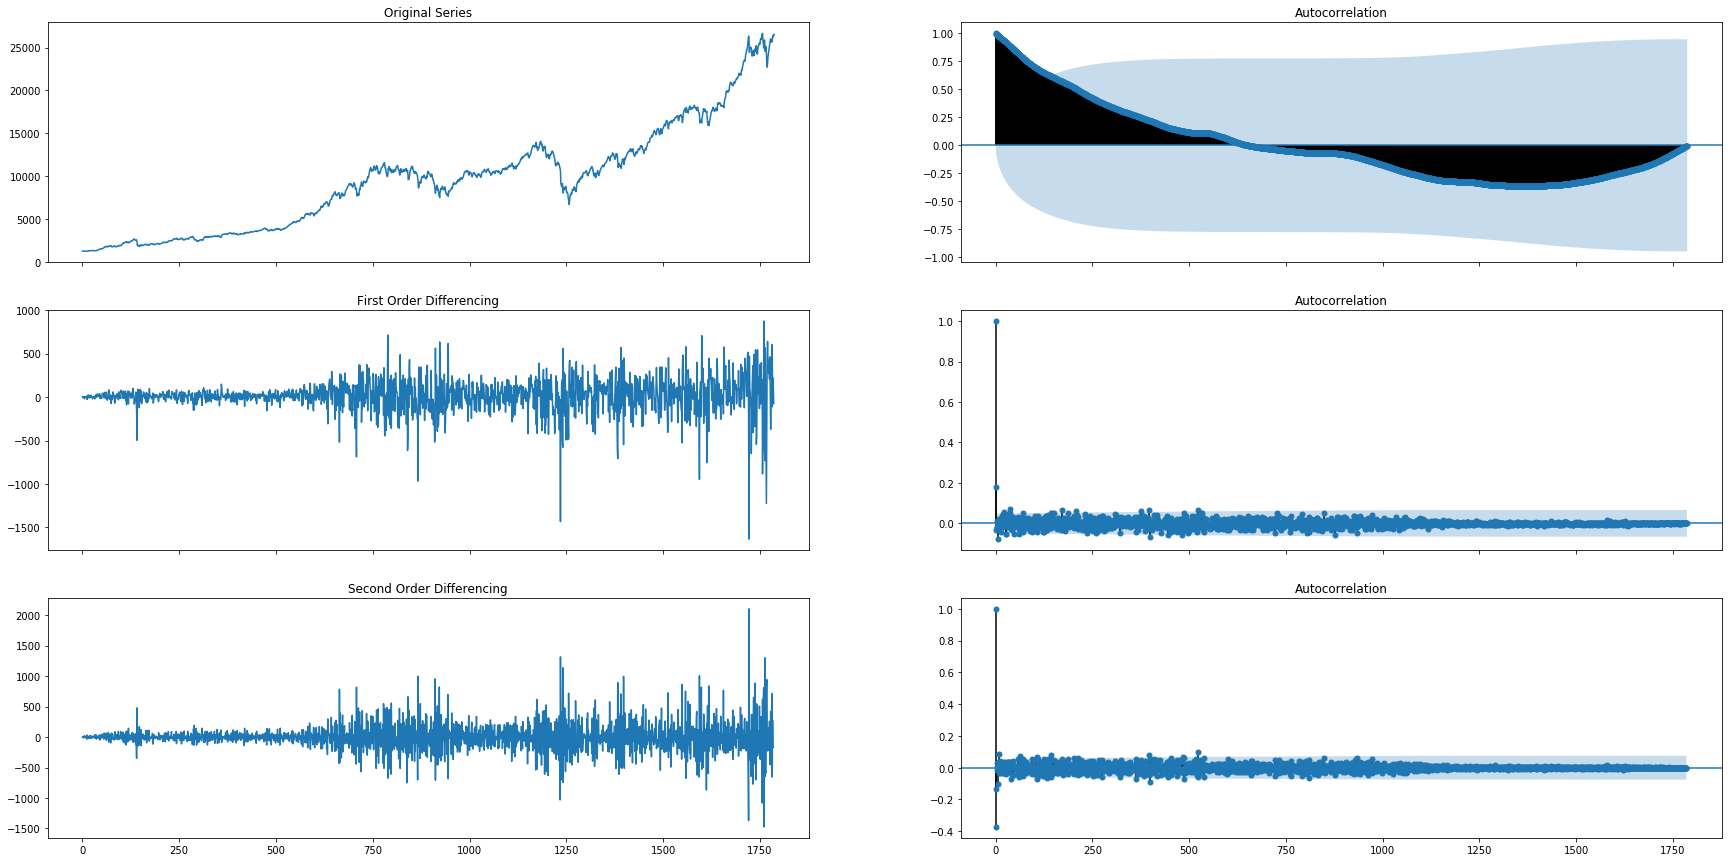

In [6]:
fig, axes = plt.subplots(3,2, figsize = (30,15), sharex = True)
axes[0,0].plot(df_dji_week.values); axes[0,0].set_title('Original Series')
plot_acf(df_dji_week.values, ax=axes[0,1])

#First Differencing
axes[1,0].plot(np.diff(df_dji_week.values, axis = 0)); axes[1,0].set_title('First Order Differencing')
plot_acf(np.diff(df_dji_week.values, axis = 0), ax = axes[1,1])

#Second Differencing
axes[2,0].plot(np.diff(np.diff(df_dji_week.values, axis = 0), axis = 0)); axes[2,0].set_title('Second Order Differencing')
plot_acf(np.diff(np.diff(df_dji_week.values, axis = 0), axis = 0), ax = axes[2,1])

plt.show()


### First Order Differencing with Ad-Fuller Test

In [7]:
adf_dji0 = adfuller(df_dji_week['Close'])
print('ADF Statistic: %f' % adf_dji0[0], 'p-value: %f' % adf_dji0[1])
adf_dji1 = adfuller(np.diff(df_dji_week['Close'], axis = 0))
print('ADF Statistic1: %f' % adf_dji1[0], 'p-value: %f' % adf_dji1[1])
adf_dji2 = adfuller(np.diff(np.diff(df_dji_week['Close'], axis = 0),axis = 0))
print('ADF Statistic2: %f' % adf_dji2[0], 'p-value: %f' % adf_dji2[1])

ADF Statistic: 1.616136 p-value: 0.997905
ADF Statistic1: -14.930922 p-value: 0.000000
ADF Statistic2: -15.115904 p-value: 0.000000


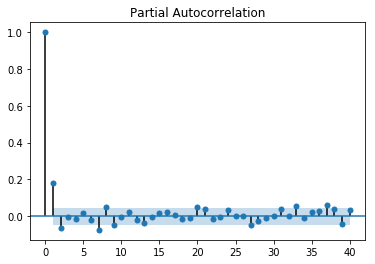

In [8]:
plot_pacf(np.diff(df_dji_week['Close'], axis = 0), lags = 40);

Note that the PACF plot has a significant spike only at lag 1, meaning that all the higher-order autocorrelations are effectively explained by the lag-1 autocorrelation. 

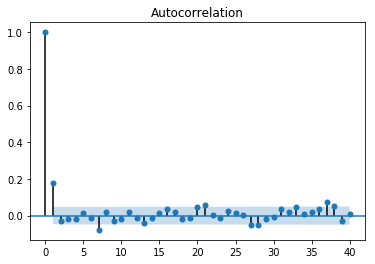

In [9]:
plot_acf(np.diff(df_dji_week['Close'], axis = 0), lags = 40);

## Fitting

In [10]:
order=np.array([1,1,1])
model_dji = ARIMA(df_dji_week, order= order)
model_dji_fit = model_dji.fit()
print(model_dji_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 1787
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -11818.994
Method:                       css-mle   S.D. of innovations            180.355
Date:                Fri, 31 May 2019   AIC                          23645.988
Time:                        12:25:18   BIC                          23667.942
Sample:                    02-10-1985   HQIC                         23654.095
                         - 05-05-2019                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            14.0971      4.993      2.824      0.005       4.312      23.882
ar.L1.D.Close    -0.1204      0.114     -1.059      0.290      -0.343       0.102
ma.L1.D.Close     0.3112      0.109     

                 0
count  1787.000000
mean     -0.007004
std     180.405115
min   -1583.322863
25%     -61.345448
50%       3.225354
75%      73.163079
max     816.299929


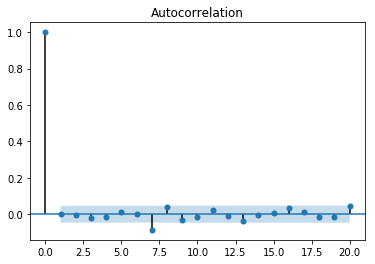

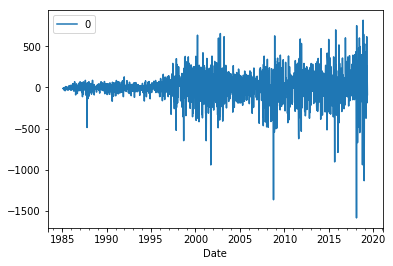

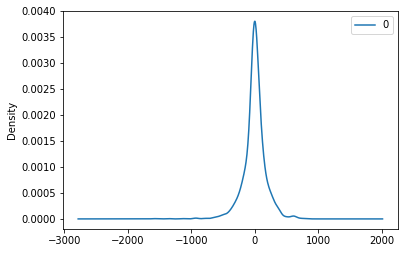

In [11]:
residuals = pd.DataFrame(model_dji_fit.resid)
plot_acf(residuals, lags = 20)
residuals.plot()
residuals.plot(kind = 'kde')
print(residuals.describe())

## Predicting

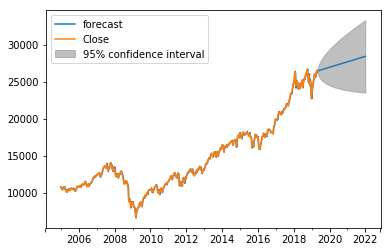

In [18]:
### model_dji_fit.plot_predict('2010', '2021', dynamic = False)
model_dji_fit.plot_predict(start = '2005', end = '2022',dynamic = False)

plt.show()

# EDA - DOW JONES INDUSTRIAL AVERAGE



## Structure: 
DOW Jones Industrial Average Data came from a CSV. Each observation is in a seperate row. There is daily a data observation for approximately 70% of days in the 34 year span of 1985 to 2019. The data is 70% of days because it is only collected on the weekdays. The data is not spread across multiple tables.


In [13]:
df_dji.head()

,Close
Date,
1985-01-29,1292.619995
1985-01-30,1287.880005
1985-01-31,1286.770020
1985-02-01,1277.719971
1985-02-04,1290.079956


In [14]:
df_dji.dtypes

Close    float64
dtype: object

## Granularity: 
Each row (observation) represents the market value of the Dow Jones at the end of the weekday. The data is not summarized or aggregated, but instead used as a time-series model for its rate of change.


In [15]:
df_dji.shape

(8636, 1)

In [16]:
df_dji.describe()

,Close
count,8636.000000
mean,9500.461189
std,6096.591724
min,1242.050049
25%,3566.230042
50%,9870.679688
75%,12453.862549
max,26828.390625


## Scope: 
Data is comprehensive of the last 34 years, with the exception of weekend observations because the stock market is open 9:30am - 4pm Eastern, Monday - Friday.

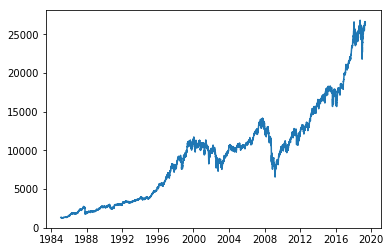

In [17]:
plt.plot(df_dji['Close'])

## Temporality: 
The date in the dataset represents the market value of the DOW at 4pm on weekdays (closing time). It is represented in YYYY-MM-DD. We plan to use this data as the x axis of our plot.

## Faithfulness: 
The data is reasonable and to be expected. The data was measured by a computer and remains consistent across time. There are no obvious signs of falsification or any reason to disbelieve the data.